hello


# `AFAD: labels 0-25 correspond to ages 15-40`

In [ ]:
!nvidia-smi

Thu Aug 19 14:54:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/AFAD/csv/afad_train.csv'
VALID_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/AFAD/csv/afad_valid.csv'
TEST_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/AFAD/csv/afad_test.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/AFAD/AFAD-Full-images'
RANDOM_SEED = 42 # 0,1,2
MODEL_NAME = "AFAD-CE_ResNet_100%"
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/' + MODEL_NAME
NUM_CLASSES = 26
BATCH_SIZE = 256
GRAYSCALE = False
learning_rate = 0.0005 #5e-4
num_epochs = 25
NUM_WORKERS = 0

In [ ]:
# GPU or CPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [ ]:
header = []

header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Output Path: {PATH}')

In [ ]:
with open(LOGFILE, 'w') as f:
    for entry in header:
        print(entry)
        f.write(f'{entry}\n')
        f.flush()

PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/AFAD-CE_ResNet_100%


# Dataset

In [ ]:
class AFADDatasetAge(Dataset):
    """Custom Dataset for loading AFAD face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path, index_col=0)
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        # self.img_paths = df['path']
        self.img_paths = df['path'].values
        self.y = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_paths[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]


In [ ]:
custom_transform_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor()])

custom_transform_test = transforms.Compose([transforms.Resize((128, 128)),
                                        transforms.CenterCrop((120, 120)),
                                        transforms.ToTensor()])

train_dataset = AFADDatasetAge(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None)

valid_dataset = AFADDatasetAge(csv_path=VALID_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_test,
                               items = None)

test_dataset = AFADDatasetAge(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH,
                              transform=custom_transform_test,
                               items = None)

In [ ]:
len(train_dataset), len(valid_dataset), len(test_dataset), 

(118491, 13165, 32762)

# Dataset Entity Distribution Analysis

In [ ]:
def dataset_analysis(dataset):
  num_of_pic_per_age = []
  ages = []
  counter = Counter(np.sort(dataset))
  for key, value in counter.items(): 
    ages.append(key+15)
    num_of_pic_per_age.append(value)

  plt.scatter(ages, num_of_pic_per_age, s=10, c='black')
  # plt.hist(torch.from_numpy(dataset).bincount())
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("Label\t\tAge\t\tCount")
  for key, value in counter.items(): print(key,'\t\t',(key+15),'\t\t', value) # UTKFace: labels 0-39 correspond to ages 21-60

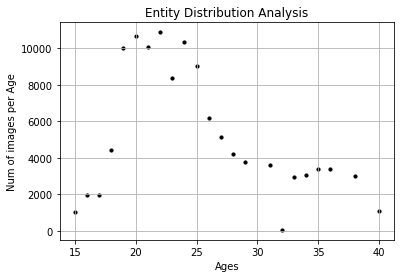

Label		Age		Count
0 		 15 		 1013
1 		 16 		 1969
2 		 17 		 1965
3 		 18 		 4419
4 		 19 		 10003
5 		 20 		 10646
6 		 21 		 10037
7 		 22 		 10872
8 		 23 		 8390
9 		 24 		 10362
10 		 25 		 9024
11 		 26 		 6162
12 		 27 		 5153
13 		 28 		 4204
14 		 29 		 3749
16 		 31 		 3581
17 		 32 		 53
18 		 33 		 2948
19 		 34 		 3078
20 		 35 		 3403
21 		 36 		 3375
23 		 38 		 3015
25 		 40 		 1070


In [ ]:
dataset_analysis(train_dataset.y)

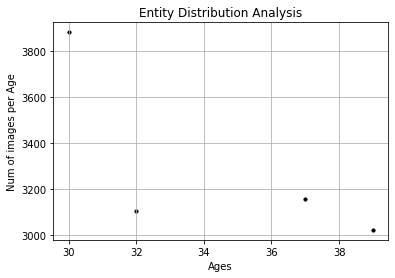

Label		Age		Count
15 		 30 		 3884
17 		 32 		 3104
22 		 37 		 3156
24 		 39 		 3021


In [ ]:
dataset_analysis(valid_dataset.y)

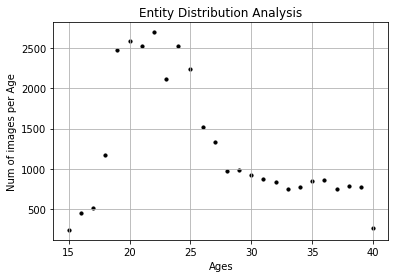

Label		Age		Count
0 		 15 		 238
1 		 16 		 454
2 		 17 		 517
3 		 18 		 1166
4 		 19 		 2474
5 		 20 		 2586
6 		 21 		 2523
7 		 22 		 2700
8 		 23 		 2120
9 		 24 		 2529
10 		 25 		 2237
11 		 26 		 1514
12 		 27 		 1328
13 		 28 		 966
14 		 29 		 981
15 		 30 		 922
16 		 31 		 875
17 		 32 		 839
18 		 33 		 753
19 		 34 		 778
20 		 35 		 843
21 		 36 		 859
22 		 37 		 742
23 		 38 		 783
24 		 39 		 770
25 		 40 		 265


In [ ]:
dataset_analysis(test_dataset.y)

In [ ]:
torch.from_numpy(train_dataset.y).bincount()

tensor([ 1013,  1969,  1965,  4419, 10003, 10646, 10037, 10872,  8390, 10362,
         9024,  6162,  5153,  4204,  3749,     0,  3581,    53,  2948,  3078,
         3403,  3375,     0,  3015,     0,  1070])

In [ ]:
torch.from_numpy(valid_dataset.y).bincount()

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 3884,    0, 3104,    0,    0,    0,    0, 3156,    0,
        3021])

In [ ]:
torch.from_numpy(test_dataset.y).bincount()

tensor([ 238,  454,  517, 1166, 2474, 2586, 2523, 2700, 2120, 2529, 2237, 1514,
        1328,  966,  981,  922,  875,  839,  753,  778,  843,  859,  742,  783,
         770,  265])

# Dataset Loader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [ ]:
len(train_loader), len(valid_loader), len(test_loader)

(463, 52, 128)

# Model

### ResNet34

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

`nn.RELU(inplace=True)` [details](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948)

Understanding the underscore( _ ) of Python [link](https://stackoverflow.com/questions/8689964/why-do-some-functions-have-underscores-before-and-after-the-function-name)

`self.modules()` [link](https://discuss.pytorch.org/t/pytorch-self-module/49677)

What do `*` and `**` before a variable name mean in a function signature? [link](https://stackoverflow.com/questions/11315010/what-do-and-before-a-variable-name-mean-in-a-function-signature)

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1) # reshaping, -1 means calculate the suitable number for second dimension 
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

# Initialize Model, and Optimizer

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES, GRAYSCALE)

model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

# Training

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [ ]:
min_valid_cost = np.inf
start_time = time.time()

for epoch in tqdm(range(num_epochs)):
  train_total_num_correct_preds = valid_total_num_correct_preds = train_num_examples = valid_num_examples = 0
 
  model.train()
  for batch_idx, (features, targets) in enumerate(tqdm(train_loader)):

    targets, features =  targets.to(DEVICE), features.to(DEVICE)

    # FORWARD AND BACK PROP
    logits, probas = model(features)
    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()
    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()
    
    train_total_num_correct_preds += calculate_correct_preds(probas, targets)
    train_num_examples += targets.size(0) 

  model.eval()
  for i, (features, targets) in enumerate(tqdm(valid_loader)):
    targets, features =  targets.to(DEVICE), features.to(DEVICE)

    logits, probas = model(features)
    cost_valid = F.cross_entropy(logits, targets)

    valid_total_num_correct_preds += calculate_correct_preds(probas, targets)
    valid_num_examples += targets.size(0)

  # LOGGING
  print(f'train_total_num_correct_preds: {train_total_num_correct_preds} | valid_total_num_correct_preds: {valid_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)
  valid_acc = compute_acc(valid_total_num_correct_preds, valid_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str = f'Epoch: {epoch+1}/{num_epochs} | Training Cost: {format(cost, ".3f")} | Training_acc: {training_acc}% | Validation Cost: {format(cost_valid, ".3f")} | Validation_acc: {valid_acc}% Time elapsed: {time_elapsed}min'
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

  if min_valid_cost > cost_valid:
    str = f'Validation Cost Decreased({format(min_valid_cost, ".3f")}--->{format(cost_valid, ".3f")}) \t_-_Saving Model_-_\n'
    print(str)
    with open(LOGFILE, 'a') as f: f.write(f'{str}\n')
    min_valid_cost = cost_valid
    
    torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

with open(LOGFILE, 'a') as f: f.write('\n\n############-------Trainig Completed-------############\n\n')

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Evaluation

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(tqdm(data_loader)):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)

    _, predicted_labels = torch.max(probas, dim=1)
    # predicted_labels = probas > 0.5
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model = resnet34(NUM_CLASSES, GRAYSCALE)
model.load_state_dict(torch.load(os.path.join(PATH, 'model.pt')))
model.to(DEVICE)
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  test_mae, test_mse, test_acc = compute_mae_and_mse(model, test_loader, device=DEVICE)

  str = f'MAE/RMSE/ACC: | Train: {train_mae}/{train_mse}/{train_acc}% | Test: {test_mae}/{test_mse}/{test_acc}%'
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} min'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')